In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import torch
import ot
import matplotlib.patches as mpatches

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Arial')
matplotlib.rcParams['mathtext.fontset']='stix'
matplotlib.rcParams['font.size']=10
pd.set_option('display.max_rows', 1000)
root = '.'

2024-05-22 19:04:29.019819: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 19:04:29.075925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 19:04:29.871707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot(dataset, figure_name='figure', x='labda', x_name='$\lambda$', ytick1=None, ytick2=None, ypad1=0.02, ypad2=0.02):
    
    dataset[x]=dataset[x].astype(str)
    f = plt.figure(dpi=400, figsize=(8,3))
    f.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.2)
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    context = ['paper', 'notebook', 'talk', 'poster']
    palette = sns.color_palette('deep')
    sns.set_theme(style=style[4], context=context[0], font='Arial', font_scale=1.6, palette=[palette[0], palette[3], palette[2]] + palette[4:])
    
    with PdfPages(f"./{figure_name}.pdf") as pdf:
        f.add_subplot(1,2,1)
        sns.lineplot(x=x, y='MAE', hue='P', data=dataset, style='P', errorbar=('ci', 90), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
        ax = plt.gca()
        ax.yaxis.set_major_locator(plt.MultipleLocator(ypad1))
        plt.legend(ncol=2, loc='upper left')
        plt.xlabel(x_name)
        plt.ylabel('MAE')
        if ytick1:
            plt.yticks(ytick1)
        # plt.text(3.6, 0.941, '$×10^{-3}$', ha='center', va='bottom')

        f.add_subplot(1,2,2)
        sns.lineplot(x=x, y='RMSE', hue='P', data=dataset, style='P', errorbar=('ci', 99.9), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
        ax = plt.gca()
        ax.yaxis.set_major_locator(plt.MultipleLocator(ypad2))
        plt.legend(ncol=2, loc='upper left')
        plt.tight_layout()
        plt.xlabel(x_name)
        plt.ylabel('RMSE')
        # plt.yscale('log')
        if ytick2:
            plt.yticks(ytick2)
        pdf.savefig(f, bbox_inches='tight', pad_inches=0.01)

In [3]:
import time
def test_time(batch_size, d, device='cpu', iter=1000000000, thr=1e-6):
    device = torch.device(device)
    dtype = torch.float64
    
    X1 = torch.randn(batch_size, d, device=device, dtype=dtype)*100 + torch.ones(batch_size,d, device=device, dtype=dtype)*100
    X2 = torch.randn(batch_size, d, device=device, dtype=dtype)*100
    a, b = torch.ones((batch_size,), dtype=dtype, device=device) / batch_size, torch.ones((batch_size,), dtype=dtype, device=device) / batch_size

    # torch.cuda.synchronize()
    start = time.time()
    M = ot.dist(X1, X2)
    M1 = ot.dist(X1, X1)
    M2 = ot.dist(X2, X2)
    result = ot.gromov.fused_gromov_wasserstein(C1=M1, C2=M2, p=a, q=b, M=M, alpha=0.01, max_iter=iter, tol_rel=thr)
    # torch.cuda.synchronize()
    end  = time.time()
    return end-start
def remove_top_bottom(group):
    top = group.sort_values(by='Time', ascending=False).iloc[:20].index
    bottom = group.sort_values(by='Time', ).iloc[:20].index
    group = group.drop(top)
    group = group.drop(bottom)
    group = group.loc[:, ['Time', 'Device']]
    return group


In [11]:
trials = 100
# device = 'cuda:2'
device='cpu'
DEVICE, D, TIME, BS, EPO = [], [], [], [], []

for batch_size in [16, 32]:
    for trial in range(trials):
        d=8
        test_time(batch_size=batch_size, d=d, device=device, iter=1000)

for batch_size in [16, 32, 64, 128, 256, 512]:
    for trial in range(trials):
        d=8
        t = test_time(batch_size=batch_size, d=d, device=device, iter=1000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(1000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=100000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(100000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=10000000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(10000000)
    print(batch_size)
time_bs = pd.DataFrame({'B': BS, 'D': D, 'Time': TIME, 'Device': DEVICE, '$\ell_\mathrm{epo}$': EPO})
time_bs_ = time_bs.groupby(['B', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


DEVICE, D, TIME, BS, EPO = [], [], [], [], []
for d in [32, 64, 128, 256, 512, 1024]:
    for trial in range(trials):
        batch_size=128
        t = test_time(batch_size=batch_size, d=d, device=device, iter=1000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(1000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=100000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(100000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=10000000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(10000000)
time_d = pd.DataFrame({'B': BS, 'D': D, 'Time': TIME, 'Device': DEVICE, '$\ell_\mathrm{epo}$': EPO})
time_d_ = time_d.groupby(['D', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


time_bs_['$\ell_\mathrm{epo}$'] = time_bs['$\ell_\mathrm{epo}$'].map({1000: '$\ell_\mathrm{max}=1\mathrm{e}^3$', 100000: '$\ell_\mathrm{max}=1\mathrm{e}^5$', 10000000: '$\ell_\mathrm{max}=1\mathrm{e}^7$'})
time_d_['$\ell_\mathrm{epo}$'] = time_d['$\ell_\mathrm{epo}$'].map({1000: '$\ell_\mathrm{max}=1\mathrm{e}^3$', 100000: '$\ell_\mathrm{max}=1\mathrm{e}^5$', 10000000: '$\ell_\mathrm{max}=1\mathrm{e}^7$'})
time_bs_['Time'] = time_bs['Time']*1000
time_d_['Time'] = time_d['Time']*1000

time_bs_.to_csv("time_cpu_bs_.csv")
time_d_.to_csv("time_cpu_d_.csv")

16
32
64
128
256
512


/tmp/ipykernel_1458897/4214594290.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_bs_ = time_bs.groupby(['B', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()
/tmp/ipykernel_1458897/4214594290.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_d_ = time_d.groupby(['D', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


/tmp/ipykernel_1458897/3315673448.py:14: UserWarning: The palette list has more values (18) than needed (3), which may not be intended.
  bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_1458897/3315673448.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_1458897/3315673448.py:34: UserWarning: The palette list has more values (18) than needed (3), which may not be intended.
  bar = sns.barplot(x='D', y='Time', hue='$\ell_\mathrm{epo}$', data=time_d_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_14588

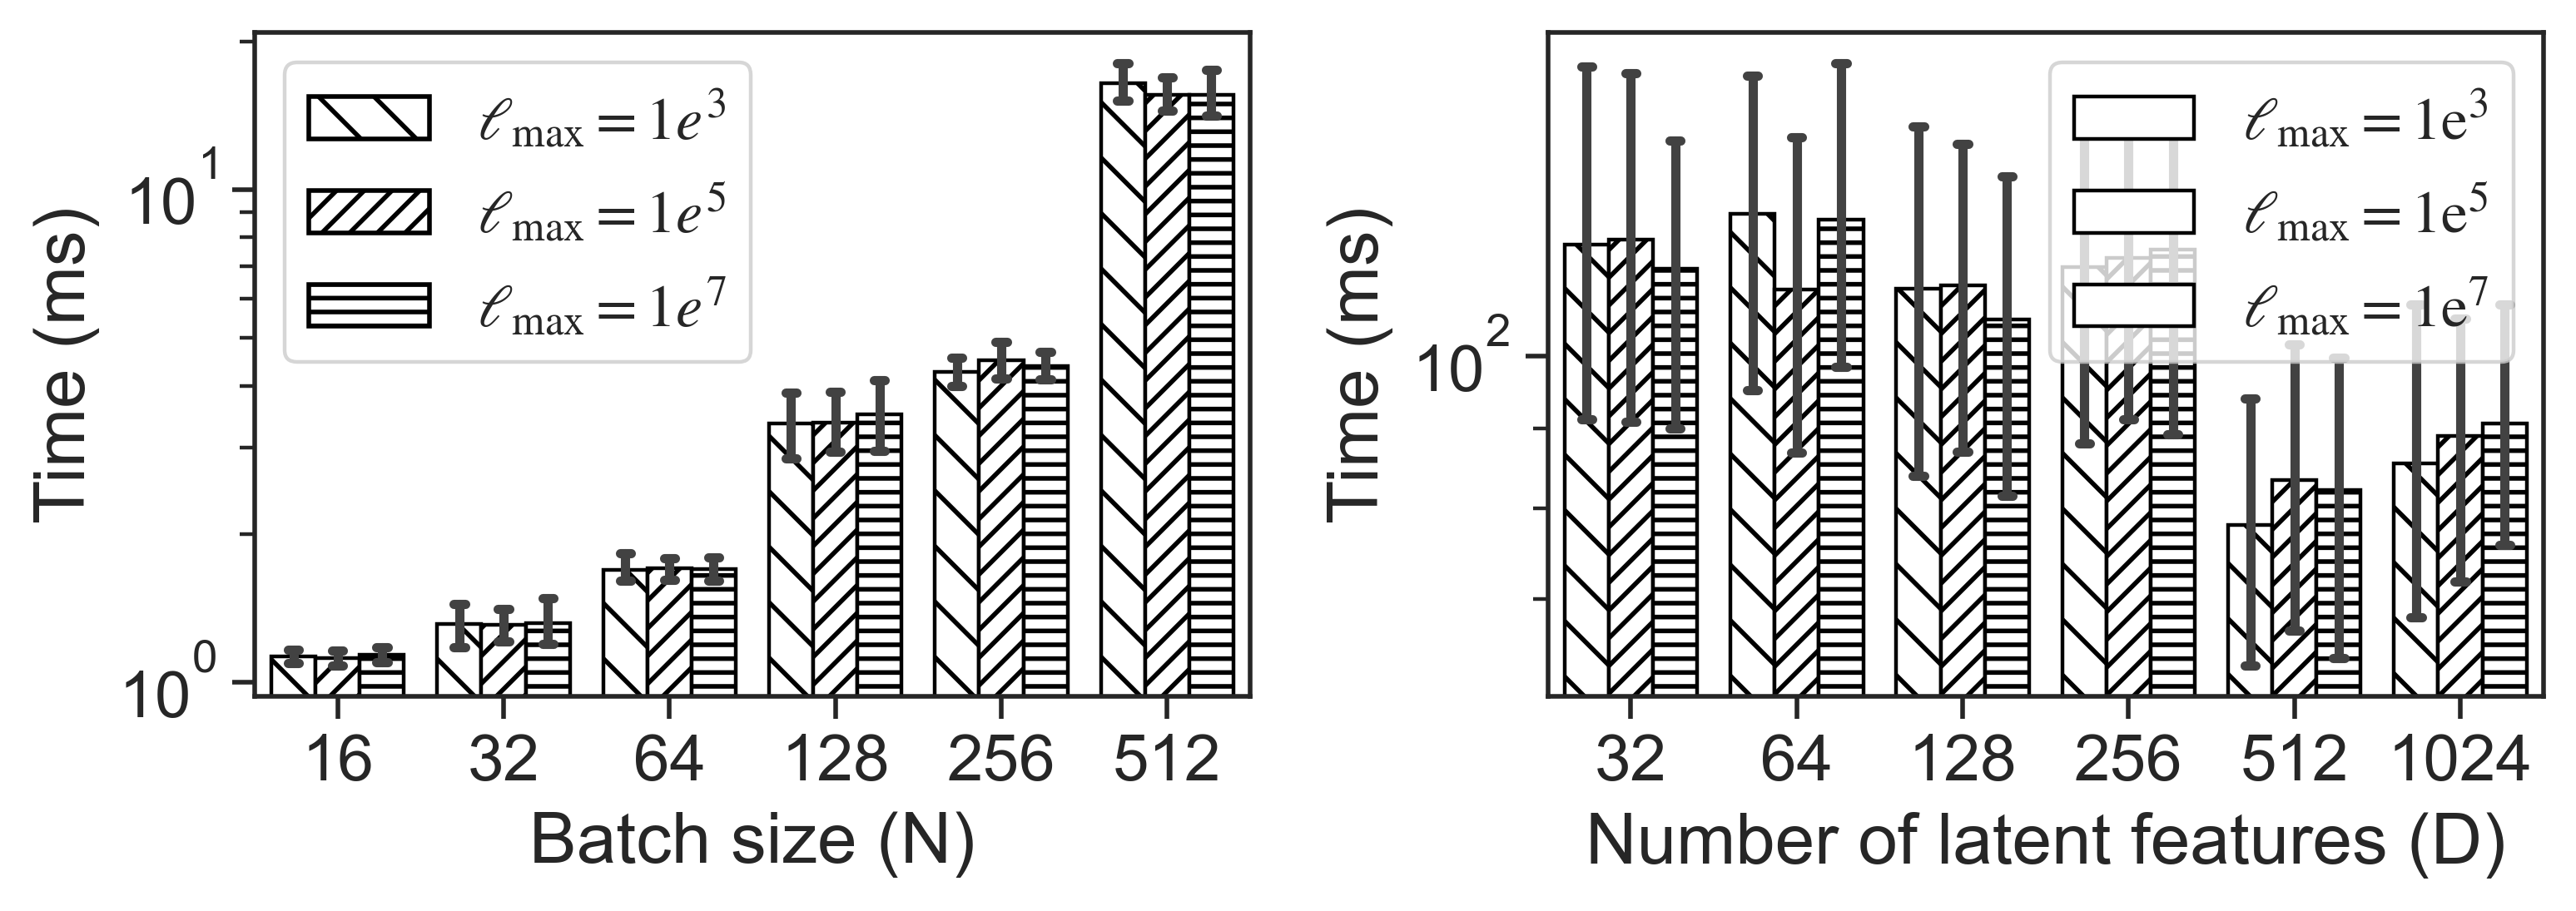

In [18]:
with PdfPages(f'figure_speed_cpu.pdf') as pdf:
    f = plt.figure(dpi=400, figsize=(8,3))
    f.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.2)
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    context = ['paper', 'notebook', 'talk', 'poster']
    palette = sns.color_palette('deep')
    sns.set_theme(style=style[4], context=context[0], font='Arial', font_scale=1.6, palette=[palette[0], palette[3], palette[2]] + palette[4:])
    
    f.add_subplot(1,2,1)
    time_bs_ = time_bs_.query('B!=2048')
    time_bs_['B'] = time_bs_['B'].astype(int)
    time_bs_ = time_bs_.sort_values(by=['B', '$\ell_\mathrm{epo}$'])
    time_bs_['B'] = time_bs_['B'].astype(str)
    bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
    
    patterns = ["\\\\"] * 6 + ["////"] * 6 + ["----"] * 6
    legend_labels = ["$\ell_\mathrm{max}=1e^3$", "$\ell_\mathrm{max}=1e^5$", "$\ell_\mathrm{max}=1e^7$"] 
    legend_patterns = ["\\\\", "////", "----"]
    legend_patches = [mpatches.Patch(facecolor='white', hatch=legend_pattern, label=legend_label, edgecolor='black', linewidth=1.0) for legend_label, legend_pattern in zip(legend_labels, legend_patterns)]
    for patch, pattern in zip(bar.patches, patterns):
        patch.set_hatch(pattern)
        patch.set_edgecolor("black")
    
    ax = plt.gca()
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.8))
    plt.legend(fontsize=13, handles=legend_patches)
    plt.xlabel('Batch size (N)'); plt.ylabel('Time (ms)'); plt.yscale('log')

    f.add_subplot(1,2,2)
    time_d_['D'] = time_d_['D'].astype(int)
    time_d_ = time_d_.sort_values(by=['D', '$\ell_\mathrm{epo}$'])
    time_d_['D'] = time_d_['D'].astype(str)
    # sns.lineplot(x='D', y='Time', hue='color', data=time_d_, style='color', errorbar=('ci', 99.9), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
    bar = sns.barplot(x='D', y='Time', hue='$\ell_\mathrm{epo}$', data=time_d_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
    
    patterns = ["\\\\"] * 6 + ["////"] * 6 + ["----"] * 6
    legend_labels = ["$\ell_\mathrm{max}=1e^3$", "$\ell_\mathrm{max}=1e^5$", "$\ell_\mathrm{max}=1e^7$"] 
    legend_patterns = ["\\\\", "////", "----"]
    legend_patches = [mpatches.Patch(facecolor='white', hatch=legend_pattern, label=legend_label, edgecolor='black', linewidth=1.0) for legend_label, legend_pattern in zip(legend_labels, legend_patterns)]
    for patch, pattern in zip(bar.patches, patterns):
        patch.set_hatch(pattern)
        patch.set_edgecolor("black")

    ax = plt.gca()
    plt.legend(fontsize=13)
    plt.xlabel('Number of latent features (D)'); plt.ylabel('Time (ms)'); plt.yscale('log')

    plt.tight_layout()
    pdf.savefig(f, bbox_inches='tight', pad_inches=0.02)

In [19]:
trials = 100
device = 'cuda:0'
# device='cpu'
DEVICE, D, TIME, BS, EPO = [], [], [], [], []

for batch_size in [16, 32]:
    for trial in range(trials):
        d=8
        test_time(batch_size=batch_size, d=d, device=device, iter=1000)

for batch_size in [16, 32, 64, 128, 256, 512]:
    for trial in range(trials):
        d=8
        t = test_time(batch_size=batch_size, d=d, device=device, iter=1000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(1000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=100000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(100000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=10000000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(10000000)
    print(batch_size)
time_bs = pd.DataFrame({'B': BS, 'D': D, 'Time': TIME, 'Device': DEVICE, '$\ell_\mathrm{epo}$': EPO})
time_bs_ = time_bs.groupby(['B', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


DEVICE, D, TIME, BS, EPO = [], [], [], [], []
for d in [32, 64, 128, 256, 512, 1024]:
    for trial in range(trials):
        batch_size=128
        t = test_time(batch_size=batch_size, d=d, device=device, iter=1000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(1000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=100000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(100000)
        t = test_time(batch_size=batch_size, d=d, device=device, iter=10000000)
        BS.append(batch_size); D.append(d); TIME.append(t); DEVICE.append(device); EPO.append(10000000)
time_d = pd.DataFrame({'B': BS, 'D': D, 'Time': TIME, 'Device': DEVICE, '$\ell_\mathrm{epo}$': EPO})
time_d_ = time_d.groupby(['D', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


time_bs_['$\ell_\mathrm{epo}$'] = time_bs['$\ell_\mathrm{epo}$'].map({1000: '$\ell_\mathrm{max}=1\mathrm{e}^3$', 100000: '$\ell_\mathrm{max}=1\mathrm{e}^5$', 10000000: '$\ell_\mathrm{max}=1\mathrm{e}^7$'})
time_d_['$\ell_\mathrm{epo}$'] = time_d['$\ell_\mathrm{epo}$'].map({1000: '$\ell_\mathrm{max}=1\mathrm{e}^3$', 100000: '$\ell_\mathrm{max}=1\mathrm{e}^5$', 10000000: '$\ell_\mathrm{max}=1\mathrm{e}^7$'})
time_bs_['Time'] = time_bs['Time']*1000
time_d_['Time'] = time_d['Time']*1000

time_bs_.to_csv("time_gpu_bs_.csv")
time_d_.to_csv("time_gpu_d_.csv")

16
32
64
128
256
512


/tmp/ipykernel_1458897/851275377.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_bs_ = time_bs.groupby(['B', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()
/tmp/ipykernel_1458897/851275377.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_d_ = time_d.groupby(['D', '$\ell_\mathrm{epo}$']).apply(remove_top_bottom).reset_index()


/tmp/ipykernel_1458897/3308800928.py:14: UserWarning: The palette list has more values (18) than needed (3), which may not be intended.
  bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_1458897/3308800928.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_1458897/3308800928.py:34: UserWarning: The palette list has more values (18) than needed (3), which may not be intended.
  bar = sns.barplot(x='D', y='Time', hue='$\ell_\mathrm{epo}$', data=time_d_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
/tmp/ipykernel_14588

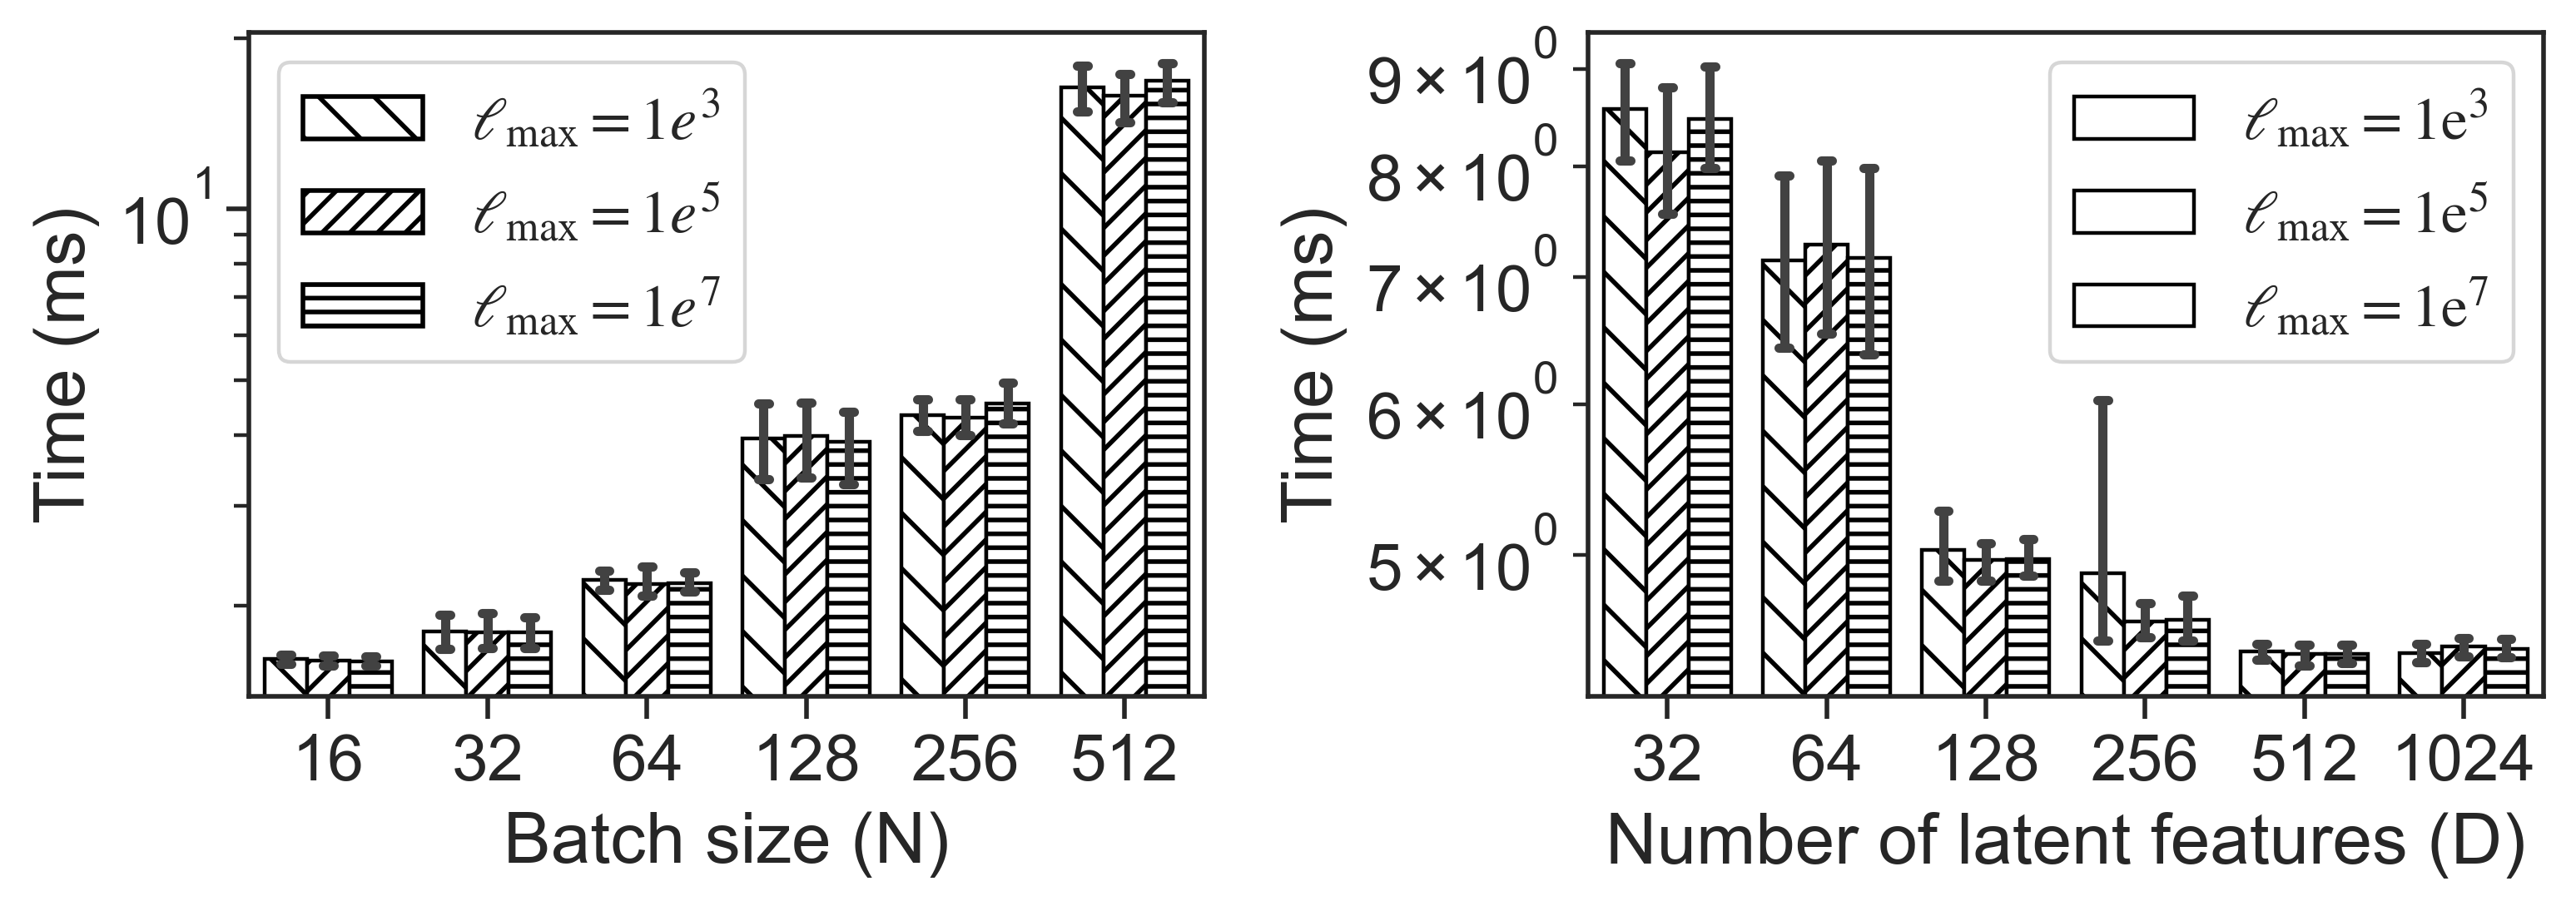

In [20]:
with PdfPages(f'figure_speed_gpu.pdf') as pdf:
    f = plt.figure(dpi=400, figsize=(8,3))
    f.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.2)
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    context = ['paper', 'notebook', 'talk', 'poster']
    palette = sns.color_palette('deep')
    sns.set_theme(style=style[4], context=context[0], font='Arial', font_scale=1.6, palette=[palette[0], palette[3], palette[2]] + palette[4:])
    
    f.add_subplot(1,2,1)
    time_bs_ = time_bs_.query('B!=2048')
    time_bs_['B'] = time_bs_['B'].astype(int)
    time_bs_ = time_bs_.sort_values(by=['B', '$\ell_\mathrm{epo}$'])
    time_bs_['B'] = time_bs_['B'].astype(str)
    bar = sns.barplot(x='B', y='Time', hue='$\ell_\mathrm{epo}$', data=time_bs_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
    
    patterns = ["\\\\"] * 6 + ["////"] * 6 + ["----"] * 6
    legend_labels = ["$\ell_\mathrm{max}=1e^3$", "$\ell_\mathrm{max}=1e^5$", "$\ell_\mathrm{max}=1e^7$"] 
    legend_patterns = ["\\\\", "////", "----"]
    legend_patches = [mpatches.Patch(facecolor='white', hatch=legend_pattern, label=legend_label, edgecolor='black', linewidth=1.0) for legend_label, legend_pattern in zip(legend_labels, legend_patterns)]
    for patch, pattern in zip(bar.patches, patterns):
        patch.set_hatch(pattern)
        patch.set_edgecolor("black")
    
    ax = plt.gca()
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.8))
    plt.legend(fontsize=13, handles=legend_patches)
    plt.xlabel('Batch size (N)'); plt.ylabel('Time (ms)'); plt.yscale('log')

    f.add_subplot(1,2,2)
    time_d_['D'] = time_d_['D'].astype(int)
    time_d_ = time_d_.sort_values(by=['D', '$\ell_\mathrm{epo}$'])
    time_d_['D'] = time_d_['D'].astype(str)
    # sns.lineplot(x='D', y='Time', hue='color', data=time_d_, style='color', errorbar=('ci', 99.9), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
    bar = sns.barplot(x='D', y='Time', hue='$\ell_\mathrm{epo}$', data=time_d_, palette=["white"]*18, errwidth=2, capsize=0.2, errorbar=('ci', 99.9), width=0.8, edgecolor='black')
    
    patterns = ["\\\\"] * 6 + ["////"] * 6 + ["----"] * 6
    legend_labels = ["$\ell_\mathrm{max}=1e^3$", "$\ell_\mathrm{max}=1e^5$", "$\ell_\mathrm{max}=1e^7$"] 
    legend_patterns = ["\\\\", "////", "----"]
    legend_patches = [mpatches.Patch(facecolor='white', hatch=legend_pattern, label=legend_label, edgecolor='black', linewidth=1.0) for legend_label, legend_pattern in zip(legend_labels, legend_patterns)]
    for patch, pattern in zip(bar.patches, patterns):
        patch.set_hatch(pattern)
        patch.set_edgecolor("black")

    ax = plt.gca()
    plt.legend(fontsize=13)
    plt.xlabel('Number of latent features (D)'); plt.ylabel('Time (ms)'); plt.yscale('log')

    plt.tight_layout()
    pdf.savefig(f, bbox_inches='tight', pad_inches=0.02)